# Elliptical Slice Sampling without mean shifting in Tensorflow
This code is largely based on the example code found [here](https://www.tensorflow.org/probability/api_docs/python/tfp/experimental/mcmc/EllipticalSliceSampler). The credit for the example used should go to [Max Hinne](https://github.com/mhinne).

# Assumptions
* The sampler assumes that the prior is a gaussian (This can be seen in the sampling step where we have to sample from a multivariate gaussian distribution).
* The sampler assumes a prior with a zero mean, as the mean is not mentioned in this implementation.




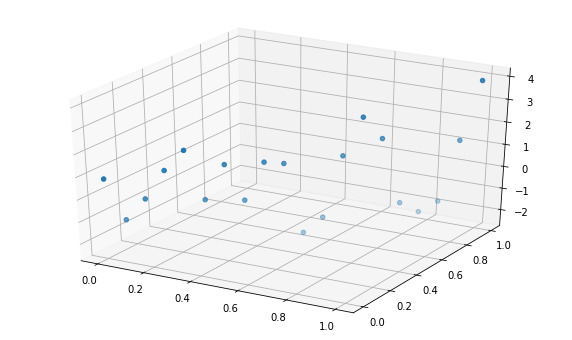

Sample mean:  tf.Tensor(
[-0.06076289 -0.26146016 -0.03024958  0.62644753  0.99338494  0.60219941
  0.26100646  0.529727    0.57412924 -0.30149252 -1.29575372 -0.98480673
  0.67904323  1.92935349  1.2254626  -0.69949995 -1.69268754 -0.71588489
  1.33426473  2.90022395], shape=(20,), dtype=float64)
Sample Std:  tf.Tensor(
[0.68084144 0.55724193 0.61440312 0.6328008  0.65901804 0.59527097
 0.57626739 0.62922493 0.65959824 0.63612757 0.60347895 0.59300098
 0.67183677 0.60108948 0.71645683 0.66973013 0.63221737 0.71304002
 0.61113129 0.77157065], shape=(20,), dtype=float64)


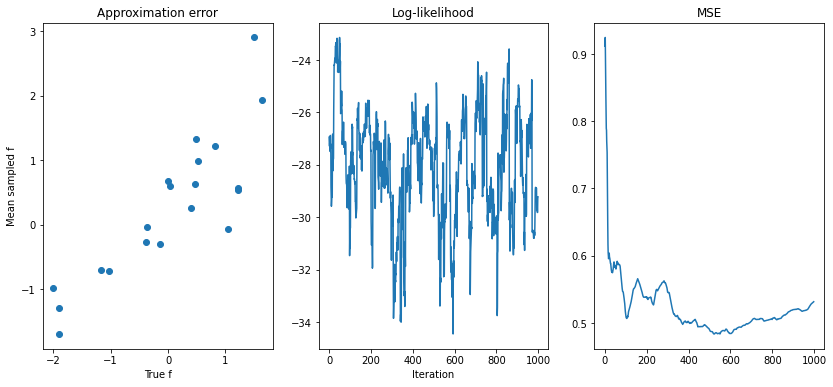

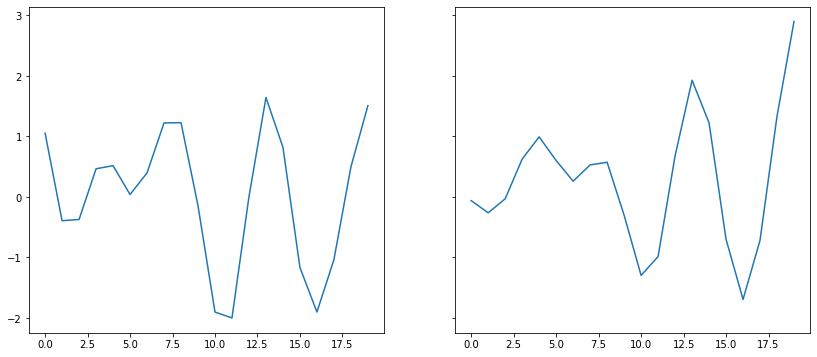

In [2]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import default_rng


tfd = tfp.distributions

dtype = np.float64

seed = 1234
np.random.seed(1234)
rng = default_rng(seed = seed)

N = 20
D = dtype(1)
x = np.expand_dims(np.linspace(0, 1, N), 1)
noise_var = dtype(1.0) 

def sq_exp(x1, x2, params=None):    
    if params is None:
        params = dict()
    length_scale = params.get('length_scale', 1.0)
    signal_variance = params.get('signal_variance', 1.0)
    return signal_variance*np.exp(-np.sum((x1-x2)**2) / (2*length_scale**2))

K = np.zeros((N, N))
for i in range(N):
    for j in range(N):
        K[i, j] = 5.0 * sq_exp(x[i], x[j], {"length_scale": 0.1})
K = K.astype(np.float64)

jitter = 1e-6 * np.eye(N)
L = np.linalg.cholesky(K + jitter)
z = np.random.normal(size=(N,))
f_prior = np.squeeze(np.dot(L, z))
data = np.random.normal(loc=f_prior, scale=noise_var).astype(np.float64)


fig = plt.figure(figsize=(10,6))
ax = fig.gca(projection='3d')
ax.scatter(x[:,0], x[:,0], data)
plt.show()

def normal_sampler_fn(seed):
    distro = tfd.MultivariateNormalFullCovariance(loc=np.zeros([N]), covariance_matrix=K,)
    sample = distro.sample(seed=seed)
    sample = tf.squeeze(sample)
    return sample

def log_likelihood_fn(f):
    result = tf.reduce_sum(tfd.Normal(f, noise_var).log_prob(data))
    return result

kernel = tfp.experimental.mcmc.EllipticalSliceSampler(
    normal_sampler_fn=normal_sampler_fn,
    log_likelihood_fn=log_likelihood_fn)

samples = tfp.mcmc.sample_chain(
    num_results=int(1000),
    current_state=normal_sampler_fn(seed),
    kernel=kernel,
    num_burnin_steps=1000,
    trace_fn=None,
    parallel_iterations=1,
    seed=seed)

sample_mean = tf.reduce_mean(samples, axis=0)
sample_std = tf.sqrt(
  tf.reduce_mean(tf.math.squared_difference(samples, sample_mean),axis=0))

error_running = [
    np.mean(np.abs(f_prior - np.mean(samples.numpy()[0:i], axis=0)))
    for i in range(1,1000)
]

print("Sample mean: ", sample_mean)
print("Sample Std: ", sample_std)

# Visualize the samples and compare to the true "posterior"
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(14, 6))
ax1.scatter(f_prior, sample_mean.numpy())
ax1.set_xlabel("True f")
ax1.set_ylabel("Mean sampled f")
ax1.set_title("Approximation error")
ax2.plot([log_likelihood_fn(s) for s in samples])
ax2.set_xlabel("Iteration")
ax2.set_title("Log-likelihood")
ax3.plot(error_running)
ax3.set_title("MSE")

if D == 1:

    fig, (ax1, ax2) = plt.subplots(
        nrows=1, ncols=2, figsize=(14, 6), sharex=True, sharey=True
    )
    ax1.plot(f_prior)
    ax2.plot(np.mean(samples.numpy(), axis=0))

    plt.show()